In [2]:
#读取数据
import numpy as np
import pandas as pd
import os

import warnings
warnings.filterwarnings('ignore',category=UserWarning,module='bs4')

root = './data'
print(os.listdir(root))

['test.tsv', 'sampleSubmission.csv', 'train.tsv']


In [3]:
#nltk是处理英文本文的一个库函数，里头包含了例如tokenizer，lemma类似的函数
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import re
from tqdm import tqdm

In [28]:
#使用keras搭建网络
from keras.utils import to_categorical # 转成one-hot
import random
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split # 划分验证集，训练集
from keras.preprocessing import sequence # 将词转成序列
from keras.preprocessing.text import Tokenizer # 来自keras的token函数
from keras.layers import Dense,Dropout,Embedding,LSTM,GRU,Conv1D,MaxPooling1D,GlobalAveragePooling1D # 网络层
from keras.callbacks import EarlyStopping # 训练提早结束
from keras.losses import categorical_crossentropy # 分类器
from keras.optimizers import Adam # 优化器
from keras.models import Sequential # 模型容器

In [5]:
# 为keras优化器固定一个随机算子，这样可以保证每次出现的结果都是相同的，便于验证
set_random_seed(123)
random.seed(123)

In [6]:
# load data
train = pd.read_csv(os.path.join(root,'train.tsv'),sep = '\t')
test = pd.read_csv(os.path.join(root,'test.tsv'),sep = '\t')
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [7]:
train.shape

(156060, 4)

In [8]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [13]:
test.shape

(66292, 3)

In [9]:
# 下面这个函数用来去除html标签
# 去除非文本内容
# tokenize句子，即分词
# lemmatize句子，即词性还原
def clean_sentences(df):
    reviews = []
    for sent in tqdm(df['Phrase']):
        review_text = BeautifulSoup(sent).get_text() # 去除html
        review_text = re.sub('[^a-zA-Z]',' ',review_text) # 去除非文本部分
        # tokenize the sentences
        words = word_tokenize(review_text.lower()) # 令牌化
        lemma_words = [lemmatizer.lemmatize(i) for i in words] # 词形恢复
        reviews.append(lemma_words)
    return reviews

In [10]:
# clear the data
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)
print(len(train_sentences))
print(len(test_sentences))

100%|██████████| 66292/66292 [01:16<00:00, 862.34it/s] 

156060
66292


In [11]:
# 将标注转变为one-hot格式
target = train.Sentiment.values
y_target = to_categorical(target)
num_classes = y_target.shape[1]

In [12]:
print(y_target.shape)

(156060, 5)


In [13]:
# split the data into train and val
x_train,x_val,y_train,y_val = train_test_split(train_sentences,y_target,test_size = 0.2,stratify=y_target)

In [14]:
# 去除重复出现的词，unique_words里头是一个单词的全集
unique_words = set()
len_max = 0
for sent in tqdm(x_train):
    unique_words.update(sent)
    if(len_max < len(sent)):
        len_max = len(sent)
print(len(list(unique_words)))
print(len_max)

100%|██████████| 124848/124848 [00:00<00:00, 362057.13it/s]

13729
48


In [15]:
list(unique_words)[:10]

['t',
 'recall',
 'pinnacle',
 'sought',
 'glitz',
 'purportedly',
 'adventure',
 'mongrel',
 'knoxville',
 'jumbled']

In [16]:
# 对句子再次进行tokenizer操作
tokenizer = Tokenizer(num_words = len(list(unique_words)))
tokenizer.fit_on_texts(list(x_train)) # 用数据初始化tokenizer
# tokenizer.word_count 返回一个字典，字典的key为词，val为出现的个数
# tokenizer.word_index 对词集合中每一个词编号,key为词，val为编号
# 将句子中的词替换成词的编号
x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)
x_test = tokenizer.texts_to_sequences(test_sentences)
# 由于每个句子的长度不一样长，因此需要对齐，通过pad在短的句子开头补上0
x_train = sequence.pad_sequences(x_train,maxlen=len_max)
x_val = sequence.pad_sequences(x_val,maxlen=len_max)
x_test = sequence.pad_sequences(x_test,maxlen=len_max)

In [17]:
print(x_train.shape,x_val.shape,x_test.shape)

(124848, 48) (31212, 48) (66292, 48)


In [18]:
list(x_train)[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,  140,  718, 1760,  820,
       1895,    3,  257,   53], dtype=int32)

In [19]:
# 设置early stop
early_stopping = EarlyStopping(min_delta=0.001,mode ='max',monitor='val_acc',patience = 2)
callback = [early_stopping]

In [68]:
# keras搭建模型
model = Sequential()
# embedding(input_dim(词汇表长度),output_dim(输出的vector的长度)，input_length(输入句子的长度))
# 等于输入了词汇表，句子的sequences，然后去学习word2vec的参数，得到表示句子的vector，长度通常设置成128或300
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))# embedding 起到word2vec的作用
# LSTM
model.add(LSTM(128,dropout=0.5,recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5,recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy',optimizer=Adam(lr = 0.005),metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 48, 300)           4121400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 48, 128)           219648    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 4,397,461
Trainable params: 4,397,461
Non-trainable params: 0
_________________________________________________________________


In [22]:
# 使用GRU代替LSTM的结果
model = Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(GRU(128,dropout=0.5,recurrent_dropout=0.5,return_sequences=True))
model.add(GRU(64,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dense(num_classes,activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy',optimizer=Adam(lr = 0.005),metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 48, 300)           4118700   
_________________________________________________________________
gru_1 (GRU)                  (None, 48, 128)           164736    
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                37056     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6500      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 4,327,497
Trainable params: 4,327,497
Non-trainable params: 0
_________________________________________________________________


In [31]:
#使用CNN代替LSTM
model = Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(Conv1D(128,10,activation='relu'))
model.add(Conv1D(128,10,activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(32,6))
model.add(Conv1D(32,6))
model.add(GlobalAveragePooling1D())
model.add(Dense(num_classes,activation = 'softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr = 0.005),metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 48, 300)           4118700   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 39, 128)           384128    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 30, 128)           163968    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 15, 128)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 10, 32)            24608     
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 5, 32)             6176      
_________________________________________________________________
global_average_pooling1d_2 ( (None, 32)                0         
__________

In [32]:
# 往模型中加入数据 CNN
history = model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=6,batch_size = 256,verbose=1,
                    callbacks=callback)

Train on 124848 samples, validate on 31212 samples
Epoch 1/6
124848/124848 [==============================] - 11s 92us/step - loss: 1.1451 - acc: 0.5505 - val_loss: 0.9457 - val_acc: 0.6205
Epoch 2/6
124848/124848 [==============================] - 8s 60us/step - loss: 0.8761 - acc: 0.6514 - val_loss: 0.8612 - val_acc: 0.6523
Epoch 3/6
124848/124848 [==============================] - 7s 58us/step - loss: 0.7827 - acc: 0.6878 - val_loss: 0.8471 - val_acc: 0.6613
Epoch 4/6
124848/124848 [==============================] - 7s 58us/step - loss: 0.7298 - acc: 0.7090 - val_loss: 0.8444 - val_acc: 0.6653
Epoch 5/6
124848/124848 [==============================] - 7s 59us/step - loss: 0.6906 - acc: 0.7238 - val_loss: 0.8494 - val_acc: 0.6619
Epoch 6/6
124848/124848 [==============================] - 8s 60us/step - loss: 0.6538 - acc: 0.7383 - val_loss: 0.8790 - val_acc: 0.6592


In [23]:
# 往模型中加入数据 GRU
history = model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=6,batch_size = 256,verbose=1,
                    callbacks=callback)

Train on 124848 samples, validate on 31212 samples
Epoch 1/6
124848/124848 [==============================] - 141s 1ms/step - loss: 0.9450 - acc: 0.6159 - val_loss: 0.8292 - val_acc: 0.6599
Epoch 2/6
124848/124848 [==============================] - 130s 1ms/step - loss: 0.7804 - acc: 0.6798 - val_loss: 0.7983 - val_acc: 0.6690
Epoch 3/6
124848/124848 [==============================] - 130s 1ms/step - loss: 0.7256 - acc: 0.6980 - val_loss: 0.7925 - val_acc: 0.6688
Epoch 4/6
124848/124848 [==============================] - 134s 1ms/step - loss: 0.7023 - acc: 0.7079 - val_loss: 0.8189 - val_acc: 0.6667


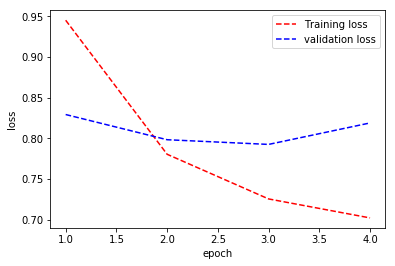

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
epoch_count = range(1,len(history.history['loss']) + 1)

plt.plot(epoch_count,history.history['loss'],'r--')
plt.plot(epoch_count,history.history['val_loss'],'b--')
plt.legend(['Training loss','validation loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [72]:
# submission
y_pred = model.predict_classes(x_test)
sub_file = pd.read_csv(os.path.join(root,'sampleSubmission.csv'),sep=',')
sub_file.Sentiment = y_pred
sub_file.to_csv('submission.csv',index = False)